## Kreditausfallwahrscheinlichkeit von Unternehmen 

Einleitung: In dieser Arbeit wird ein kreditrisikobasiertes Portfolio-Modell entwickelt, welches auf der Schätzung unternehmensspezifischer Ausfallwahrscheinlichkeiten basiert. Aufbauend auf einem Credit-Scoring-Modell werden implizite Ratings abgeleitet und mithilfe des Vasicek-Modells systematische Risikoeffekte auf Portfolioebene analysiert. Ziel ist die Quantifizierung von Worst-Case-Ausfallraten unter Stressszenarien.

#### Inhaltsverzeichnis
##### 1. Problemstellung
##### 2. Datenaufbereitung - Welche Variablen sollten in der Analyse benutzt werden?
##### 3. Datenmodellierung
- 3.1 Logistische Regression (PD-Schätzung)
- 3.2 Ableitung von impliziten Ratings (A - CCC)
##### 4. Portfolioanalyse
- 4.1 Konstruktion eines Kreditportfolios
- 4.2 Rating-Migrationsmatrizen
##### 5. Modellevaluation - Vasicek-Modell
- 5.1 Worst-Case Default Rate
- 5.2 Vasicek-Modell - Simulation der jährlichen Portfolioausrate
- 5.3 Vasicek-Modell - Schätzung der Parameter aus historischen Daten
##### 6. Szenario- & Stresstests
- 6.1 Rezessionsszenario (Makro-Schock)
- 6.2 Erhöhte Korrelation (Unternehmensabhängigkeit)
- 6.3 Erhöhte Probability of Default (Unternehmensstress)
- 6.4 Darstellung der Ergebnisse
##### 7. Interpretation

### 1. Problemstellung

Ein Unternehmen möchte anhand eines bestehenden Datensatzes zu Kreditausfällen von 6818 Unternehmen Kreditausfallwahrscheinlichkeiten unter bestimmten Voraussetzungen bestimmen. Besondere wirtschaftliche Situationen, wie eine Rezession, können einen stark negativen Effekt auf die Kreditausfallwahrscheinlichkeit von Unternehmen haben, wodurch durch Abhängigkeiten und einem starken wirtschaftlichen Abfall mehr Unternehmen ihre Kredite nicht mehr zurückzahlen können. Aus diesem Grund ist es für Banken und Versicherungen relevant, wie stark das Risiko ihres Kreditportfolios ist und wie sich das Risiko unter bestimmten Szenarien verändert. 

Forschungsfrage: Wie kann auf Basis von Unternehmensfinanzkennzahlen eine Kreditausfallwahrscheinlichkeit geschätzt und das Portfoliorisiko unter Berücksichtigung systematischer Risiken modelliert werden?

### 2. Datenaufbereitung

In [51]:
import pandas as pd # damit die Daten geladen werden können
df = pd.read_csv("data.csv", sep=",")

In [52]:
df.head(10000)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


#### Welche Variablen werden in der Untersuchung berücksichtigt und warum?

| Variable                                       | Warum                          |
| ---------------------------------------------- | ------------------------------ |
| **X33 – Current Ratio**                        | kurzfristige Zahlungsfähigkeit |
| **X58 – Quick Assets / Current Liabilities**   | realistische Liquidität        |
| **X84 – Current Liabilities / Current Assets** | Stressindikator                |
| **X3 – ROA(B)**                     | stärkster Prädiktor für Insolvenz |
| **X1 / X2 – ROA Varianten**         | Robustheit der Ertragskraft         |
| **X4 – Operating Gross Margin**     | Operative Marge                     |
| **X6 – Operating Profit Rate**      | Kernergebnis                        |
| **X86 – Net Income / Total Assets** | Gesamtprofitabilität                |
| **X36 – Total Debt / Equity**           | Klassiker           |
| **X37 – Liability / Assets**            | Leverage            |
| **X85 – Liability-Assets Flag**         | extremes Warnsignal |
| **X77 – Current Liability / Liability** | Fälligkeitsstruktur |
| **X13 – Cash Flow / Current Liabilities** | Schuldendienstfähigkeit |
| **X80 – Cash Flow / Total Assets**        | Nachhaltigkeit          |




#### 3.1 Logistische Regression (PD-Schätzung)

In [53]:
# Zielvariable
y = df["Bankrupt?"]

# Features (Y entfernen)
X = df.drop(columns=["Bankrupt?"])

In [54]:
# 1. Spalten bereinigen
df.columns = df.columns.str.strip()  # führende/trailing Leerzeichen entfernen

# 2. Feature-Liste
selected_features = [
    "ROA(C) before interest and depreciation before interest",
    "ROA(B) before interest and depreciation after tax",
    "Operating Gross Margin",
    "Cash flow rate",
    "Current Ratio",
    "Total debt/Total net worth",
    "Debt ratio %",
    "Working Capital to Total Assets",
    "Retained Earnings to Total Assets",
    "Liability-Assets Flag",
    "Net Income Flag"
]

# 3. Features & Ziel
X = df[selected_features]  # <- hier keine Anführungszeichen um selected_features
y = df["Bankrupt?"]

X = X.fillna(0)


In [67]:
## Train-Test Split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [68]:
## Logistische Regression - PD-Modell

from sklearn.linear_model import LogisticRegression

# Es wird ein balanciertes logistisches Regressionsmodell verwendet um die kleine Anzahl an Ausfällen zu berücksichtigen.
pd_model = LogisticRegression(
    max_iter=1000,
    solver="lbfgs",
    class_weight='balanced'
)

pd_model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [69]:
## Ausfallwahrscheinlichkeit berechnen

# PD für jedes Unternehmen
pd_values = pd_model.predict_proba(X)[:, 1]

df["PD"] = pd_values

In [70]:
## Modellgüte prüfen

from sklearn.metrics import roc_auc_score

pd_test = pd_model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, pd_test)

auc

0.842412764003673

#### 3.2 Ableitung von impliziten Ratings (AAA–CCC)

In [78]:
def pd_to_rating(pd):
    if pd < 0.05:       # z.B. statt 0.01 für AAA
        return "AAA"
    elif pd < 0.10:
        return "AA"
    elif pd < 0.20:
        return "A"
    elif pd < 0.35:
        return "BBB"
    elif pd < 0.50:
        return "BB"
    else:
        return "CCC"

# Rating auf den DataFrame anwenden
df["Rating"] = df["PD"].apply(pd_to_rating)

In [79]:
df["Rating"].value_counts()

Rating
CCC    6818
BB        1
Name: count, dtype: int64

In [81]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# 1. Spalten bereinigen
X.columns = X.columns.str.strip().str.replace(" ", "_").str.replace("(", "").str.replace(")", "")

# 2. NaNs behandeln
X = X.fillna(0)

# 3. Features skalieren
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Train-Test Split (stratified!)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# 5. Logistische Regression mit Balanced Class Weight
pd_model = LogisticRegression(max_iter=2000, class_weight="balanced")
pd_model.fit(X_train, y_train)

# 6. PD für jedes Unternehmen berechnen
df["PD"] = pd_model.predict_proba(X_scaled)[:, 1]

# 7. PD prüfen
print(df[["Bankrupt?", "PD"]].head(10))
print(df["PD"].describe())


   Bankrupt?        PD
0          1  0.993638
1          1  0.719863
2          1  0.888176
3          1  0.866441
4          1  0.268396
5          1  0.972383
6          0  0.985887
7          0  0.083989
8          0  0.035189
9          0  0.114691
count    6.819000e+03
mean     2.238096e-01
std      2.724947e-01
min      8.974089e-08
25%      1.847074e-02
50%      9.769992e-02
75%      3.431393e-01
max      1.000000e+00
Name: PD, dtype: float64


In [82]:
def pd_to_rating(pd):
    if pd < 0.01:
        return "AAA"
    elif pd < 0.02:
        return "AA"
    elif pd < 0.05:
        return "A"
    elif pd < 0.10:
        return "BBB"
    elif pd < 0.20:
        return "BB"
    elif pd < 0.50:
        return "B"
    else:
        return "CCC"

df["Rating"] = df["PD"].apply(pd_to_rating)

# Verteilung der Ratings prüfen
print(df["Rating"].value_counts())


Rating
B      1327
AAA    1222
CCC    1149
BB      907
A       874
BBB     790
AA      550
Name: count, dtype: int64


### 4. Portfolioanalyse
#### 4.1 Konstruktion eines Kreditportfolios

In [83]:
import numpy as np

n = len(df)
df["Portfolio_Weight"] = 1 / n  # Gleichgewichtete Kredite

In [85]:
portfolio_pd = (df["PD"] * df["Portfolio_Weight"]).sum()
print("Erwartete Portfolio-Ausfallwahrscheinlichkeit:", portfolio_pd)

Erwartete Portfolio-Ausfallwahrscheinlichkeit: 0.22380962761739834


#### 4.2 Rating-Migrationsmatrizen 

Basierend auf PD-Veränderungen werden szenario-basierte Vorhersagen getroffen (Normal / Stress)

In [86]:
import numpy as np
import pandas as pd

# 1. Aktuelle Ratings
ratings_old = df["Rating"].copy()

# 2. PD-Veränderungen simulieren
np.random.seed(42)

# Szenario: Normal (±5% PD-Änderung)
pd_new_normal = df["PD"] * (1 + np.random.uniform(-0.05, 0.05, size=len(df)))
pd_new_normal = np.clip(pd_new_normal, 0, 1)  # PDs zwischen 0 und 1

# Szenario: Stress (+50% PD)
pd_new_stress = np.clip(df["PD"] * 1.5, 0, 1)

# 3. Neue Ratings ableiten (wie vorher)
def pd_to_rating(pd):
    if pd < 0.01:
        return "AAA"
    elif pd < 0.02:
        return "AA"
    elif pd < 0.05:
        return "A"
    elif pd < 0.10:
        return "BBB"
    elif pd < 0.20:
        return "BB"
    elif pd < 0.50:
        return "B"
    else:
        return "CCC"

ratings_new_normal = pd.Series(pd_new_normal).apply(pd_to_rating)
ratings_new_stress = pd.Series(pd_new_stress).apply(pd_to_rating)

# 4. Migrationsmatrix berechnen
migration_matrix_normal = pd.crosstab(ratings_old, ratings_new_normal, normalize='index')
migration_matrix_stress = pd.crosstab(ratings_old, ratings_new_stress, normalize='index')

print("Normal-Szenario:")
print(migration_matrix_normal)

print("\nStress-Szenario:")
print(migration_matrix_stress)


Normal-Szenario:
PD             A        AA       AAA         B        BB       BBB       CCC
Rating                                                                      
A       0.969108  0.018307  0.000000  0.000000  0.000000  0.012586  0.000000
AA      0.018182  0.969091  0.012727  0.000000  0.000000  0.000000  0.000000
AAA     0.000000  0.006547  0.993453  0.000000  0.000000  0.000000  0.000000
B       0.000000  0.000000  0.000000  0.971364  0.012057  0.000000  0.016579
BB      0.000000  0.000000  0.000000  0.014333  0.970232  0.015436  0.000000
BBB     0.015190  0.000000  0.000000  0.000000  0.022785  0.962025  0.000000
CCC     0.000000  0.000000  0.000000  0.011314  0.000000  0.000000  0.988686

Stress-Szenario:
PD             A        AA       AAA         B        BB       BBB       CCC
Rating                                                                      
A       0.510297  0.000000  0.000000  0.000000  0.000000  0.489703  0.000000
AA      0.609091  0.390909  0.000000  0.0

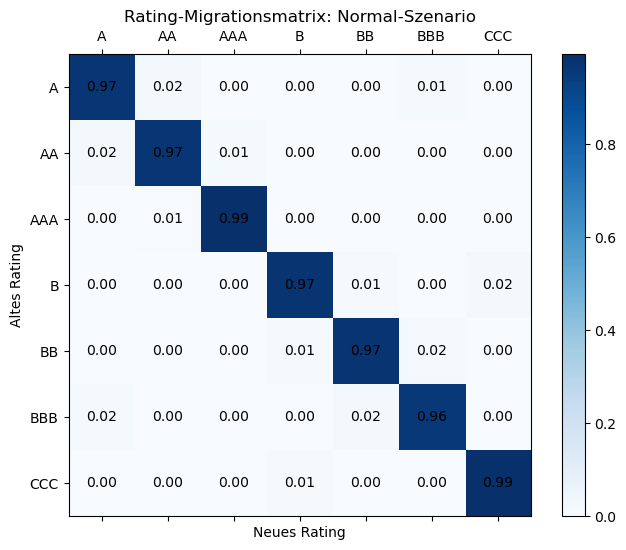

In [88]:
import matplotlib.pyplot as plt
import numpy as np

# Normal-Szenario Matrix
matrix = migration_matrix_normal.values
labels = migration_matrix_normal.columns

fig, ax = plt.subplots(figsize=(8,6))
cax = ax.matshow(matrix, cmap="Blues")

# Farbskala
fig.colorbar(cax)

# Achsenbeschriftung
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(migration_matrix_normal.index)

# Werte auf die Zellen schreiben
for i in range(len(labels)):
    for j in range(len(labels)):
        ax.text(j, i, f"{matrix[i,j]:.2f}", ha="center", va="center", color="black")

plt.title("Rating-Migrationsmatrix: Normal-Szenario")
plt.xlabel("Neues Rating")
plt.ylabel("Altes Rating")
plt.show()


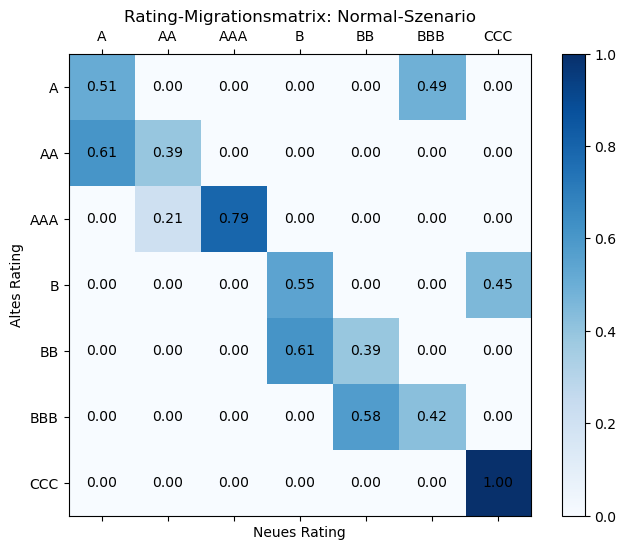

In [89]:
import matplotlib.pyplot as plt
import numpy as np

# Normal-Szenario Matrix
matrix = migration_matrix_stress.values
labels = migration_matrix_stress.columns

fig, ax = plt.subplots(figsize=(8,6))
cax = ax.matshow(matrix, cmap="Blues")

# Farbskala
fig.colorbar(cax)

# Achsenbeschriftung
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(migration_matrix_normal.index)

# Werte auf die Zellen schreiben
for i in range(len(labels)):
    for j in range(len(labels)):
        ax.text(j, i, f"{matrix[i,j]:.2f}", ha="center", va="center", color="black")

plt.title("Rating-Migrationsmatrix: Stress-Szenario")
plt.xlabel("Neues Rating")
plt.ylabel("Altes Rating")
plt.show()


### 5. Vasicek-Modell 

#### 5.1 Worst Case Default Rate

In [91]:
import numpy as np
from scipy.stats import norm

PD = df["PD"].values
rho = 0.15
alpha = 0.999
n_sim = 10000  # kleiner machen, um Speicher zu sparen

portfolio_default_rate = []

for _ in range(n_sim):
    Z = np.random.normal()
    # Ausfallrate für diese Simulation
    default_rates = norm.cdf((norm.ppf(PD) - np.sqrt(rho)*Z)/np.sqrt(1-rho))
    portfolio_default_rate.append(default_rates.mean())

portfolio_default_rate = np.array(portfolio_default_rate)

# Worst-Case Default Rate
WCDR = np.percentile(portfolio_default_rate, 99.9)
print("Worst-Case Default Rate (99,9%):", WCDR)



Worst-Case Default Rate (99,9%): 0.48232973372778337


#### 5.2 Vasicek-Modell - Simulation der jährlichen Portfolioausfallrate

Durchschnittliche Ausfallrate: 0.22356509746895853
Median: 0.2173188613247908
Worst-Case 99,9%: 0.49102037510674135


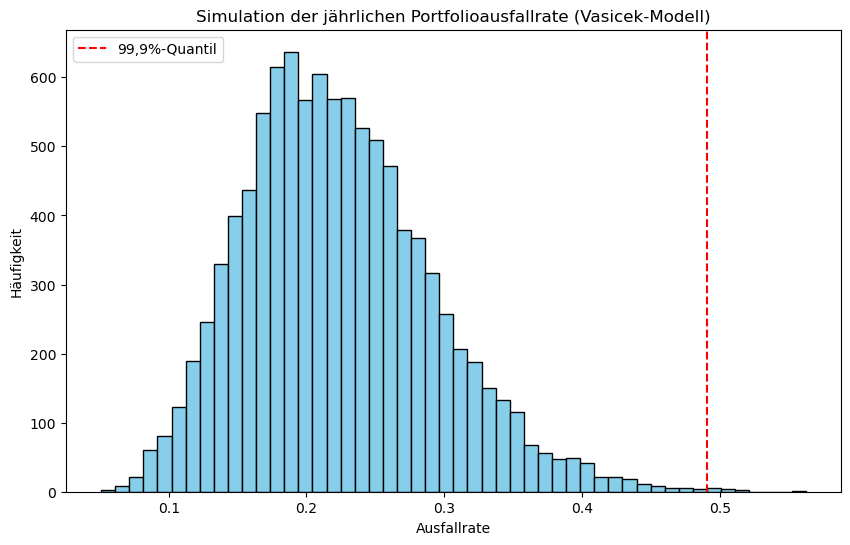

In [92]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Parameter
PD = df["PD"].values               # Ausfallwahrscheinlichkeiten
rho = 0.15                         # Asset-Korrelation
n_sim = 10000                       # Anzahl der Simulationen (Jahre)

portfolio_default_rate = []

# Simulation
for _ in range(n_sim):
    Z = np.random.normal()  # systematisches Risiko
    # Ausfallrate für jedes Unternehmen
    default_rates = norm.cdf((norm.ppf(PD) - np.sqrt(rho)*Z)/np.sqrt(1-rho))
    # Durchschnittliche Ausfallrate im Portfolio
    portfolio_default_rate.append(default_rates.mean())

portfolio_default_rate = np.array(portfolio_default_rate)

# Statistiken
print("Durchschnittliche Ausfallrate:", portfolio_default_rate.mean())
print("Median:", np.median(portfolio_default_rate))
print("Worst-Case 99,9%:", np.percentile(portfolio_default_rate, 99.9))

# Histogramm visualisieren
plt.figure(figsize=(10,6))
plt.hist(portfolio_default_rate, bins=50, color="skyblue", edgecolor="black")
plt.axvline(np.percentile(portfolio_default_rate, 99.9), color='red', linestyle='--', label="99,9%-Quantil")
plt.title("Simulation der jährlichen Portfolioausfallrate (Vasicek-Modell)")
plt.xlabel("Ausfallrate")
plt.ylabel("Häufigkeit")
plt.legend()
plt.show()


#### 5.3 Vasicek-Modell - Schätzung der Parameter aus historischen Daten

In [93]:
import numpy as np

# Beispiel: historische jährliche Ausfallraten deines Portfolios
# (hier simulierter Verlauf aus bisherigen PDs)
historical_DR = portfolio_default_rate  # z. B. 10.000 simulierte Jahre

# Durchschnittliche Ausfallrate
mean_DR = np.mean(historical_DR)

# Varianz der Ausfallrate
var_DR = np.var(historical_DR)

# Schätzung der Asset-Korrelation rho
rho_est = var_DR / (mean_DR * (1 - mean_DR))
rho_est = np.clip(rho_est, 0, 1)  # sicherstellen, dass 0 <= rho <= 1

print("Durchschnittliche Ausfallrate:", mean_DR)
print("Varianz der Ausfallrate:", var_DR)
print("Geschätzte Asset-Korrelation rho:", rho_est)

Durchschnittliche Ausfallrate: 0.22356509746895853
Varianz der Ausfallrate: 0.0046971848719758605
Geschätzte Asset-Korrelation rho: 0.02706005035842769


### 6. Szenario- & Stresstests

#### 6.1 Rezessionsszenario (Makro-Schock)

In [97]:
from scipy.stats import norm
import numpy as np

PD = df["PD"].values
rho = 0.15
n_sim = 10000

portfolio_DR_recession = []

for _ in range(n_sim):
    Z = np.random.normal(loc=-2)  # starke Rezession
    dr = norm.cdf((norm.ppf(PD) - np.sqrt(rho)*Z) / np.sqrt(1-rho))
    portfolio_DR_recession.append(dr.mean())

portfolio_DR_recession = np.array(portfolio_DR_recession)

print("Rezession – Ø Ausfallrate:", portfolio_DR_recession.mean())
print("Rezession – 99,9% WCDR:", np.percentile(portfolio_DR_recession, 99.9))

Rezession – Ø Ausfallrate: 0.3834943221602933
Rezession – 99,9% WCDR: 0.6773984124792918


#### 6.2 Erhöhte Korrelation (Konzentrationsrisiko)

In [95]:
rho_stress = 0.30

portfolio_DR_corr = []

for _ in range(n_sim):
    Z = np.random.normal()
    dr = norm.cdf((norm.ppf(PD) - np.sqrt(rho_stress)*Z) / np.sqrt(1-rho_stress))
    portfolio_DR_corr.append(dr.mean())

portfolio_DR_corr = np.array(portfolio_DR_corr)

print("Hohe Korrelation – Ø Ausfallrate:", portfolio_DR_corr.mean())
print("Hohe Korrelation – 99,9% WCDR:", np.percentile(portfolio_DR_corr, 99.9))

Hohe Korrelation – Ø Ausfallrate: 0.22462809031125425
Hohe Korrelation – 99,9% WCDR: 0.6246438798117908


#### 6.3 Erhöhte PD (Unternehmensstress)

In [96]:
PD_stress = np.clip(PD * 1.5, 0, 1)  # +50% PD

portfolio_DR_PD = []

for _ in range(n_sim):
    Z = np.random.normal()
    dr = norm.cdf((norm.ppf(PD_stress) - np.sqrt(rho)*Z) / np.sqrt(1-rho))
    portfolio_DR_PD.append(dr.mean())

portfolio_DR_PD = np.array(portfolio_DR_PD)

print("PD-Stress – Ø Ausfallrate:", portfolio_DR_PD.mean())
print("PD-Stress – 99,9% WCDR:", np.percentile(portfolio_DR_PD, 99.9))

PD-Stress – Ø Ausfallrate: 0.30604165566154523
PD-Stress – 99,9% WCDR: 0.5498058940589184


#### 6.4 Darstellung der Ergebnisse

In [106]:
import pandas as pd
import numpy as np

results = pd.DataFrame({
    "Szenario": [
        "Rezession",
        "Erhöhte Korrelation",
        "Erhöhte PD",
    ],
    "Ø Ausfallrate": [
        portfolio_DR_recession.mean(),
        portfolio_DR_corr.mean(),
        portfolio_DR_PD.mean(),
    ],
    "99.9% WCDR": [
        np.percentile(portfolio_DR_recession, 99.9),
        np.percentile(portfolio_DR_corr, 99.9),
        np.percentile(portfolio_DR_PD, 99.9),
    ]
})

results


,Szenario,Ø Ausfallrate,99.9% WCDR
0,Rezession,0.383494,0.677398
1,Erhöhte Korrelation,0.224628,0.624644
2,Erhöhte PD,0.306042,0.549806


### 7. Interpretation

Der vorliegende Datensatz aus Bestandskrediten von Unternehmen wurde auf seine Ausfallwahrscheinlichkeit ("Probability of Default") analysiert. In Abschnitt 3 wurde eine logistische Regression durchgeführt, bei der die Wahrscheinlichkeit von Default unter einer begrenzten Anzahl an Parametern berechnet wurde. Anhanddessen wurde eine Rating-Migrationsmatrix erstellt, die darstellt wie hoch die Wahrscheinlichkeit eines höheren und niedrigeren Ratings von Unternehmen ist. Bei normaler Veränderung der Ausfallwahrscheinlichkeit um 5% bleiben die Kategorien relativ stabil. Lediglich eine Veränderung bis zu 2% für ein Upgrade oder Downgrad in andere Kategorien ist möglich. Im Falle eines Stress-Szenarios (einer Verschlechterung der PD um 50%) können Unternehmen mit einem A Rating zu einer Wahrscheinlichkeit von 49% ein Rating von BBB haben. Vergleichsweise verschlechtern sich Unternehmen mit B-Rating zu 45% auf CCC. Die Worst-Case Default Rate berechnet die Ausfallwahrscheinlichkeit ("PD's") von Unternehmen zu einer bestimmten Wahrscheinlichkeit. Im Falle einer Begrenzung auf 99,9% beträgt die Ausfallwahrscheinlichkeit des Portfolios 0,48 (48% der Unternehmen fallen im schlimmsten Fall aus). Jedoch gehen wir von einer durchschnittlichen jährlichen Ausfallrate von 22% der Unternehmen aus.
Die oben dargestellte Tabelle beschreibt die Ergebnisse in verschiedenen Szenarien: Im Fall einer Rezession ist die Ausfallwahrscheinlichkeit des Portfolios mit 38% und einer WCDR am höchsten, weshalb wir davon ausgehen, dass die Verschlechterung der PD um 50% im Falle einer Rezession den größten Effekt auf die Ausfallwahrscheinlchkeit von Unternehmen hat. Gleichzeitig sehen wir auch, dass die WCDR sich im Falle einer höheren Korrelation (realistischer) zwischen der Ausfallwahrscheinlichkeiten von Unternehmen mit 62% deutlich höher ist als im normalen Modell.